<a href="https://colab.research.google.com/github/Mark-Barbaric/Introduction_To_Machine_Learning/blob/master/FinalAssignment/Final_Assignment_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Assignment - Titanic Dataset**

This is the final assignment for the course, where we attempt to predict whether someone survived the Titanic based on a number of input factors:

1. Passenger Class
2. Sex
3. Age
4. No. siblings / spouses aboard the Titanic
5. No. parents / children aboard the Titanic
6. Ticket Number
7. Passenger Fare
8. Cabin Number
9. Point of Embarkment (C = Cherbourg, Q = Queenstown, S = Southampton)


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

# **Methods**


In [0]:
def delete_cabin_data(ds):
  copy = ds.copy
  del copy['Cabin']
  return copy

def populate_missing_ages(ds):
  copy = ds.copy();
  copy["Age"].fillna(train_data.groupby("Sex")["Age"].transform("mean"), inplace=True)
  copy["Age"] = train_data["Age"].astype(float).round(1)
  return copy

def convert_non_digit_inputs(ds):
  copy = ds.copy()
  copy = train_data.replace({'Sex': {'male': 1, 'female': 0}})
  copy = train_data.replace({'Embarked': {'C': 1, 'Q': 2, 'S': 3}})
  return copy

# **Step 1: Loading and Checking Data**

First step is to load data and address the missing entries.

In [3]:
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


In [238]:
train_data = pd.read_csv('train.csv')
train_data

PassengerId  Pclass  ... Embarked Survived
0              1       3  ...        S        0
1              2       1  ...        C        1
2              3       3  ...        S        1
3              4       1  ...        S        1
4              5       3  ...        S        0
..           ...     ...  ...      ...      ...
886          887       2  ...        S        0
887          888       1  ...        S        1
888          889       3  ...        S        0
889          890       1  ...        C        1
890          891       3  ...        Q        0

[891 rows x 12 columns]

In [239]:
# check and display and missing values
train_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

Upon initial review of the Dataset, there are a number of Data Integrity issues which need to be addressed before the model can be built.

**1. Missing age entries:** there are currently 177 missing entries for age, which is a significant proportion of the input. The most viable option is to fill these values with the averages of each sex.

**2. Significant Missing Entries with Cabin Names:** the cabin name inputs are missing nearly 700 entries, which is far too many to be addressed, so the only viable option is to remove this input.

**3. Inconsistent Pattern with Ticket Data:** ticket data entries vary between 6 digit codes, and combination of Letters and digits, which doesn't present an immediately obvious pattern. Immediate response is to remove this input, but it may be worth including for the first iteration of the model, and then create a new model after removing this input.


# **Step 2: Remove Cabin Data Column**

First step is to remove Cabin column as it has far too few entries to contribute anything to the model, and there is no way of populating the missing entries in a scientific way.


In [240]:
del train_data['Cabin']
train_data

PassengerId  Pclass  ... Embarked Survived
0              1       3  ...        S        0
1              2       1  ...        C        1
2              3       3  ...        S        1
3              4       1  ...        S        1
4              5       3  ...        S        0
..           ...     ...  ...      ...      ...
886          887       2  ...        S        0
887          888       1  ...        S        1
888          889       3  ...        S        0
889          890       1  ...        C        1
890          891       3  ...        Q        0

[891 rows x 11 columns]

In [241]:
train_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Survived         0
dtype: int64

# **Step 3: Replace missing Age data with averages**

First attempt is to replace the missing Age values with the averages for each sex. Makes sense to apply the average split based on sex as there was likely to be a much larger differential in mean ages between genders in the early 1900s.

In [242]:
train_data["Age"].fillna(train_data.groupby("Sex")["Age"].transform("mean"), inplace=True)
train_data["Age"] = train_data["Age"].astype(float).round(1)
train_data

PassengerId  Pclass  ... Embarked Survived
0              1       3  ...        S        0
1              2       1  ...        C        1
2              3       3  ...        S        1
3              4       1  ...        S        1
4              5       3  ...        S        0
..           ...     ...  ...      ...      ...
886          887       2  ...        S        0
887          888       1  ...        S        1
888          889       3  ...        S        0
889          890       1  ...        C        1
890          891       3  ...        Q        0

[891 rows x 11 columns]

In [243]:
train_data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Survived       0
dtype: int64

There appear to be two missing entries in the embarked section. Printing out these two entries shows that they both have the same ticket number, which suggests that they embarked at the same destination. Before this is dealt with, it is worth reviewing all non unique ticket entries to ensure that they are either families or have the same embark destination.

In [244]:
train_data[train_data.isna().any(axis=1)]

PassengerId  Pclass  ... Embarked Survived
61            62       1  ...      NaN        1
829          830       1  ...      NaN        1

[2 rows x 11 columns]

In [245]:
train_data[train_data.duplicated(subset = ['Ticket'], keep = False)].sort_values(by = ['Ticket'])

PassengerId  Pclass  ... Embarked Survived
257          258       1  ...        S        1
759          760       1  ...        S        1
504          505       1  ...        S        1
262          263       1  ...        S        0
558          559       1  ...        S        1
..           ...     ...  ...      ...      ...
736          737       3  ...        S        0
86            87       3  ...        S        0
147          148       3  ...        S        0
540          541       1  ...        S        1
745          746       1  ...        S        0

[344 rows x 11 columns]

Have also Identified a few instances where non unique ticket number groups have different embarkment locations. There are only a handful so it shouldn't have too significant an impact on the model, but it isn't entirely clear whether they are erroneous or explanable. It could be a case of family members buying tickets from different countries and joining the Titanic at different Embarkment locations. There is also some evidence to suggest that it is erroneous data, as one or two of the instances also had missing age data and were logged as non-survivors. Given how insignificant these entries are, I have decided to continue to include them in the training data. 

The null Embarkment Destination ticket entries on the other hand will be removed.

In [246]:
train_data = train_data.dropna()
train_data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Survived       0
dtype: int64

In [247]:
train_data

PassengerId  Pclass  ... Embarked Survived
0              1       3  ...        S        0
1              2       1  ...        C        1
2              3       3  ...        S        1
3              4       1  ...        S        1
4              5       3  ...        S        0
..           ...     ...  ...      ...      ...
886          887       2  ...        S        0
887          888       1  ...        S        1
888          889       3  ...        S        0
889          890       1  ...        C        1
890          891       3  ...        Q        0

[889 rows x 11 columns]

In [248]:
train_data.count(0)

PassengerId    889
Pclass         889
Name           889
Sex            889
Age            889
SibSp          889
Parch          889
Ticket         889
Fare           889
Embarked       889
Survived       889
dtype: int64

# **Step 4: Perform Final Tidy Up Data Fame**

This includes removing unnecessary columns, printing an output of statistical summaries of the dataset to make sure that averages, max, min values are within reason, and normalizing the remaining inputs to improve the training results.


In [249]:
train_data.describe()

PassengerId      Pclass         Age  ...       Parch        Fare    Survived
count   889.000000  889.000000  889.000000  ...  889.000000  889.000000  889.000000
mean    446.000000    2.311586   29.685827  ...    0.382452   32.096681    0.382452
std     256.998173    0.834700   12.981200  ...    0.806761   49.697504    0.486260
min       1.000000    1.000000    0.400000  ...    0.000000    0.000000    0.000000
25%     224.000000    2.000000   22.000000  ...    0.000000    7.895800    0.000000
50%     446.000000    3.000000   30.000000  ...    0.000000   14.454200    0.000000
75%     668.000000    3.000000   35.000000  ...    0.000000   31.000000    1.000000
max     891.000000    3.000000   80.000000  ...    6.000000  512.329200    1.000000

[8 rows x 7 columns]

In [250]:
del train_data['Name']
del train_data['Ticket']
train_data

PassengerId  Pclass     Sex   Age  ...  Parch     Fare  Embarked Survived
0              1       3    male  22.0  ...      0   7.2500         S        0
1              2       1  female  38.0  ...      0  71.2833         C        1
2              3       3  female  26.0  ...      0   7.9250         S        1
3              4       1  female  35.0  ...      0  53.1000         S        1
4              5       3    male  35.0  ...      0   8.0500         S        0
..           ...     ...     ...   ...  ...    ...      ...       ...      ...
886          887       2    male  27.0  ...      0  13.0000         S        0
887          888       1  female  19.0  ...      0  30.0000         S        1
888          889       3  female  27.9  ...      2  23.4500         S        0
889          890       1    male  26.0  ...      0  30.0000         C        1
890          891       3    male  32.0  ...      0   7.7500         Q        0

[889 rows x 9 columns]

In [251]:
train_data['Family'] = train_data['SibSp'] + train_data['Parch'] + 1
del train_data['SibSp']
del train_data['Parch']
train_data = train_data[['PassengerId', 'Pclass', 'Sex', 'Age', 'Family', 'Fare', 'Embarked', 'Survived']]
train_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


PassengerId  Pclass     Sex   Age  Family     Fare Embarked  Survived
0              1       3    male  22.0       2   7.2500        S         0
1              2       1  female  38.0       2  71.2833        C         1
2              3       3  female  26.0       1   7.9250        S         1
3              4       1  female  35.0       2  53.1000        S         1
4              5       3    male  35.0       1   8.0500        S         0
..           ...     ...     ...   ...     ...      ...      ...       ...
886          887       2    male  27.0       1  13.0000        S         0
887          888       1  female  19.0       1  30.0000        S         1
888          889       3  female  27.9       4  23.4500        S         0
889          890       1    male  26.0       1  30.0000        C         1
890          891       3    male  32.0       1   7.7500        Q         0

[889 rows x 8 columns]

Need to reformat the Sex and Embarked Inputs so that they can be used as training inputs for the model. Sex is simply, and can simply be converted to a category as there are only two types (Male/Female). As there are three possibly input types for Embarked, One-Hot-Encoding is going to have to be used.

In [252]:
# Converting Sex to 1/0 inputs
train_data['Sex'] = train_data['Sex'].astype('category')
train_data['Sex'] = train_data['Sex'].cat.codes
train_data

PassengerId  Pclass  Sex   Age  Family     Fare Embarked  Survived
0              1       3    1  22.0       2   7.2500        S         0
1              2       1    0  38.0       2  71.2833        C         1
2              3       3    0  26.0       1   7.9250        S         1
3              4       1    0  35.0       2  53.1000        S         1
4              5       3    1  35.0       1   8.0500        S         0
..           ...     ...  ...   ...     ...      ...      ...       ...
886          887       2    1  27.0       1  13.0000        S         0
887          888       1    0  19.0       1  30.0000        S         1
888          889       3    0  27.9       4  23.4500        S         0
889          890       1    1  26.0       1  30.0000        C         1
890          891       3    1  32.0       1   7.7500        Q         0

[889 rows x 8 columns]

In [253]:
#Need to convert the Embarked Inputs to one hot encoded inputs.
train_data = pd.concat([train_data, 
                        pd.get_dummies(train_data['Embarked'], prefix = 'Embarked')], axis = 1)
del train_data['Embarked']
train_data

PassengerId  Pclass  Sex  ...  Embarked_C  Embarked_Q  Embarked_S
0              1       3    1  ...           0           0           1
1              2       1    0  ...           1           0           0
2              3       3    0  ...           0           0           1
3              4       1    0  ...           0           0           1
4              5       3    1  ...           0           0           1
..           ...     ...  ...  ...         ...         ...         ...
886          887       2    1  ...           0           0           1
887          888       1    0  ...           0           0           1
888          889       3    0  ...           0           0           1
889          890       1    1  ...           1           0           0
890          891       3    1  ...           0           1           0

[889 rows x 10 columns]

In [254]:
# Finally need to rearrange panda to Survived is the last column
train_data = train_data[['PassengerId', 'Pclass', 'Sex', 'Age', 'Family', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']]
train_data

PassengerId  Pclass  Sex  ...  Embarked_Q  Embarked_S  Survived
0              1       3    1  ...           0           1         0
1              2       1    0  ...           0           0         1
2              3       3    0  ...           0           1         1
3              4       1    0  ...           0           1         1
4              5       3    1  ...           0           1         0
..           ...     ...  ...  ...         ...         ...       ...
886          887       2    1  ...           0           1         0
887          888       1    0  ...           0           1         1
888          889       3    0  ...           0           1         0
889          890       1    1  ...           0           0         1
890          891       3    1  ...           1           0         0

[889 rows x 10 columns]

In [255]:
dataset = train_data.values
dataset

array([[  1.,   3.,   1., ...,   0.,   1.,   0.],
       [  2.,   1.,   0., ...,   0.,   0.,   1.],
       [  3.,   3.,   0., ...,   0.,   1.,   1.],
       ...,
       [889.,   3.,   0., ...,   0.,   1.,   0.],
       [890.,   1.,   1., ...,   0.,   0.,   1.],
       [891.,   3.,   1., ...,   1.,   0.,   0.]])

In [0]:
x = dataset[:,1:9]
y = dataset[:, 9]

In [257]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled_x = min_max_scaler.fit_transform(x)
scaled_x

array([[1.        , 1.        , 0.27135678, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.47236181, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.32160804, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.        , 0.34547739, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.32160804, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.39698492, ..., 0.        , 1.        ,
        0.        ]])

# **Step 5: Splitting the Test and Training Data**

The final step before creating the model involves splitting the training dataset into testing and training.

In [258]:
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size = 0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size = 0.5)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(533, 8) (178, 8) (178, 8) (533,) (178,) (178,)


# **Step 6: Building and Training The Neural Network**

Going to build and train a model based on the below specifications:

*   Hidden Layer 1: 32 Neurons, ReLU Activation
*   Dropout Layer: 40% Dropout Rate
*   Hidden Layer 2: 32 Neurons, ReLU Activation
*   Dropout Layer: 40% Dropout Rate
*   Output Layer: 1 Neuron, Sigmoid Activation

In [0]:
model = tf.keras.Sequential([tf.keras.layers.Dense(9, activation = 'relu', input_shape = (8,)),
                            tf.keras.layers.Dense(9,  activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
                            tf.keras.layers.Dense(5,   activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
                            tf.keras.layers.Dense(1, activation = 'sigmoid')])

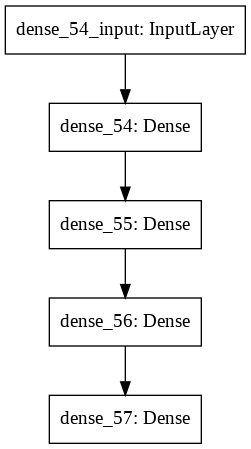

In [267]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
# configure the model
model.compile(optimizer = 'sgd', loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [269]:
hist = model.fit(x_train, y_train,
                 batch_size = 32, epochs = 500,
                 validation_data = (x_val, y_val))

Epoch 1/500
17/17 [==============================] - 0s 10ms/step - loss: 1.0515 - accuracy: 0.5403 - val_loss: 0.9479 - val_accuracy: 0.6236
Epoch 2/500
17/17 [==============================] - 0s 3ms/step - loss: 0.8451 - accuracy: 0.6642 - val_loss: 0.8528 - val_accuracy: 0.6011
Epoch 3/500
17/17 [==============================] - 0s 3ms/step - loss: 0.7887 - accuracy: 0.6848 - val_loss: 0.8837 - val_accuracy: 0.6236
Epoch 4/500
17/17 [==============================] - 0s 3ms/step - loss: 0.7638 - accuracy: 0.6773 - val_loss: 0.8089 - val_accuracy: 0.6180
Epoch 5/500
17/17 [==============================] - 0s 3ms/step - loss: 0.7694 - accuracy: 0.6942 - val_loss: 1.2940 - val_accuracy: 0.6236
Epoch 6/500
17/17 [==============================] - 0s 3ms/step - loss: 0.7749 - accuracy: 0.6698 - val_loss: 0.9227 - val_accuracy: 0.6236
Epoch 7/500
17/17 [==============================] - 0s 3ms/step - loss: 0.7772 - accuracy: 0.6867 - val_loss: 0.8284 - val_accuracy: 0.6180
Epoch 8/500


In [270]:
model.evaluate(x_test, y_test)[1]

6/6 [==============================] - 0s 1ms/step - loss: 0.5023 - accuracy: 0.7472


0.7471910119056702

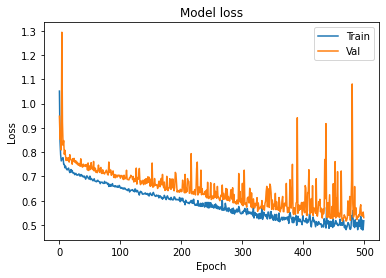

In [271]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

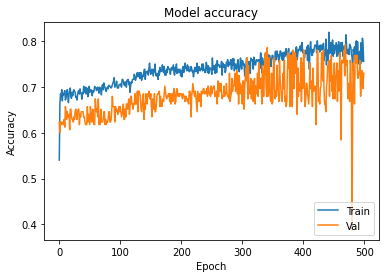

In [272]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

# **Step 7 - Predict Test Data**


